In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.integrate import cumulative_trapezoid
from numba import njit, vectorize

%matplotlib widget

In [2]:
@njit
def f(u, x):
    return 0.5 * x*x*x * np.sin(u / x/x)**2 

@njit
def fbp(u, x):
    return 0.5 * x * np.sin(2 * u /x/x)


@vectorize
def heaviside(x):
    if x < 0:
        return 0
    elif x > 0:
        return 1
    else:
        return 0.5

@njit
def TDV_RK(r, u_prev, xs, h, dt, nghost):
    if r == 2:
        return TDV_RK3(u_prev, xs, h, dt, nghost)
    else:
        raise Exception("Order not implemented! r = 2")


@njit
def L(r, j, u, E, fup, xs, h, nghost):
    """
    Equation 2.7b

    u  --> array of sol
    xs --> array of grid
    
    x_jm = x_{j - 1/2}
    x_jM = x_{j + 1/2}

    R(r, j  , x_jM, u, fup, xs, h) = f(x_{j + 1/2})
    """
    x_jM = xs[j] + h / 2
    x_jm = xs[j] - h / 2
    if j == nghost:
        o1, Bplus, idxA = flux( R(r, j  , x_jM, u, fup, xs, h), R(r, j+1, x_jM, u, fup, xs, h), x_jM) 
        o2, Bmin, idxB  = 0, 0, -1
    else:
        o1, Bplus, idxA = flux( R(r, j  , x_jM, u, fup, xs, h), R(r, j+1, x_jM, u, fup, xs, h), x_jM) 
        o2, Bmin, idxB  = flux( R(r, j-1, x_jm, u, fup, xs, h), R(r, j  , x_jm, u, fup, xs, h), x_jm)

    if idxA == 1:
        e_k = E[j]
    elif idxA == -1:
        e_k = E[j+1]
    elif idxA == 0:
        e_k = 0

    if idxB == 1:
        e_l = E[j-1]
    elif idxB == -1:
        e_l = E[j]
    elif idxB == 0:
        e_l = 0

    return - ( o1 - o2 ) / h, Bplus, Bmin, e_k, e_l

@njit
def R(r, j, x_pt, u, fup, xs, h):
    if r == 2:
        return R2(j, x_pt, u, fup, xs, h)

@njit
def alpha(r, j, i, u, fup, x, h):
    if r == 2:
        return alpha_r2(j, i, u, fup, x, h)

@njit
def interpolants(r, j, x, u, xs, h):
    if r == 2:
        return interp_r2(j, x, u, xs, h)

@njit
def SI(r, j, u):
    if r == 2:
        return SI_r2(j, u)

# @njit
# def flux(a, b, x):
#     """
#     Roe flux function
#     Equation 2.6
#     """
#     u_dec = np.linspace(min(a,b), max(a,b))
#     der = fp(u_dec, x)
#     if np.all(der >= 0):
#         return f(a, x)
#     elif np.all(der < 0):
#         return f(b, x)
#     else:
#         beta = np.max(np.abs(der)) 
#         return 0.5* (f(a, x) + f(b, x) - beta * (b - a))

# @njit
# def flux(a, b, x):
#     """
#     Godunov flux function
#     Equation 2.5
#     """
#     u_dec = np.linspace(min(a,b), max(a,b), 100)
#     ff = f(u_dec, x)
#     if a <= b:
#         return np.min(ff)
#     elif a > b:
#         return np.max(ff)

# @njit
# def flux(a, b, x):
#     ul = a/x/x
#     ur = b/x/x
#     FL = 0.5 * x**3 * np.sin(ul)**2 
#     FR = 0.5 * x**3 * np.sin(ur)**2 
#     if ul <= ur:
#         return min(FL, FR)
#     elif ul > ur:
#         if ((ur > -np.pi/2) or (ul < -np.pi/2)):
#             return max(FL, FR)
#         else:
#             return 0.5 * x**3

@njit
def flux(a, b, x):
    ul = a/x/x
    ur = b/x/x
    FL = 0.5 * x**3 * np.sin(ul)**2 
    FR = 0.5 * x**3 * np.sin(ur)**2 
    if ul <= ur:
        if FL < FR:
            return FL, a, 1
        else:
            return FR, b, -1
    elif ul > ur:
        if ((ur > -np.pi/2) or (ul < -np.pi/2)):
            if FL > FR:
                return FL, a, 1
            else:
                return FR, b, -1
        else:
            return 0.5 * x**3, a, 0


@njit
def BC(arr, Ndiv):
    # Specific for nghost = 1

    arr[0] = arr[1]
    arr[Ndiv-1] = arr[Ndiv-2]
    arr[Ndiv] = arr[Ndiv+1]
    arr[-1] = arr[-2]
    return arr

# @njit
# def BC(arr, nghost):
#     for i in range(nghost):
#         arr[i] = arr[nghost + 1 - i]
#     # arr[:nghost] = arr[nghost:2*nghost]
#     arr[-nghost:] = arr[-nghost - 1]
#     return arr

@njit
def TDV_RK3(u_prev, xs, h, dt, nghost):
    """
    ## TO OPTIMIZE

    1**) Euler step t      --> t +   dt
    2**) Euler step t + dt --> t + 2*dt
    
    3**) Weighted mean btw t and t+2*dt to find t + dt/2
    
    4**) Euler step t + dt/2 -- > t + 3*dt/2
    
    5**) Weighted mean btw t and t+3*dt/2 to find  t + dt
    """
    rr = np.zeros(int(len(xs) - 2*nghost))
    Ndiv = len(xs)
    
    u_n1    = np.zeros_like(u_prev)
    u_n2    = np.zeros_like(u_prev)
    u_n12   = np.zeros_like(u_prev)
    u_n32   = np.zeros_like(u_prev)
    u_final = np.zeros_like(u_prev)


    # 1**)
    fBp = fbp(u_prev[:Ndiv], xs)

    B_p = u_prev[:Ndiv].copy()
    E_p = u_prev[Ndiv:].copy()

    # B(1) = 0
    u_n1[nghost] = 0
    # E(1) = 0
    u_n1[Ndiv + nghost] = 0
    for j in range(nghost+1, Ndiv - nghost -1):
        rr, Bplus, Bmin, Ek, El = L(2, j, B_p, E_p, fBp, xs, h, nghost)
        # B(j)
        u_n1[j] = B_p[j] + dt * (rr + E_p[j])
        # E(j)
        u_n1[Ndiv + j] = E_p[j] + dt * ( fbp(Bplus, xs[j] + 0.5*h) * (E_p[j]  - Ek) + fbp(Bmin, xs[j] - 0.5*h) * (El - E_p[j]) ) / h
    # B(N)
    u_n1[Ndiv-2] = B_p[-2]
    # E(N)
    u_n1[-2] = E_p[-2]
    # Ghosts
    u_n1 = BC(u_n1, Ndiv)


    # 2**)
    fBp = fbp(u_n1[:Ndiv], xs)

    B_p = u_n1[:Ndiv].copy()
    E_p = u_n1[Ndiv:].copy()

    # B(1) = 0
    u_n2[nghost] = 0
    # E(1) = 0
    u_n2[Ndiv + nghost] = 0
    for j in range(nghost+1, Ndiv - nghost -1):
        rr, Bplus, Bmin, Ek, El = L(2, j, B_p, E_p, fBp, xs, h, nghost)
        # B(j)
        u_n2[j] = B_p[j] + dt * (rr + E_p[j])
        # E(j)
        u_n2[Ndiv + j] = E_p[j] + dt * ( fbp(Bplus, xs[j] + 0.5*h) * (E_p[j]  - Ek) + fbp(Bmin, xs[j] - 0.5*h) * (El - E_p[j]) ) / h
    # B(N)
    u_n2[Ndiv-2] = B_p[-2]
    # E(N)
    u_n2[-2] = E_p[-2]
    # Ghosts
    u_n2 = BC(u_n2, Ndiv)


    # 3**)
    # B(1) = 0
    u_n12[nghost] = 0
    # E(1) = 0
    u_n12[Ndiv + nghost] = 0
    for j in range(nghost+1, Ndiv - nghost -1):
        u_n12[j] = 3 * u_prev[j] / 4 + u_n2[j] / 4
        u_n12[Ndiv + j] = 3 * u_prev[Ndiv + j] / 4 + u_n2[Ndiv + j] / 4
    # B(N)
    u_n12[Ndiv-2] = B_p[-2]
    # E(N)
    u_n12[-2] = E_p[-2]
    u_n12 = BC(u_n12, Ndiv)

    # 4**)
    fBp = fbp(u_n12[:Ndiv], xs)

    B_p = u_n12[:Ndiv].copy() 
    E_p = u_n12[Ndiv:].copy()

    # B(1) = 0
    u_n32[nghost] = 0
    # E(1) = 0
    u_n32[Ndiv + nghost] = 0
    for j in range(nghost+1, Ndiv - nghost -1):
        rr, Bplus, Bmin, Ek, El = L(2, j, B_p, E_p, fBp, xs, h, nghost)
        # B(j)
        u_n32[j] = B_p[j] + dt * (rr + E_p[j])
        # E(j)
        u_n32[Ndiv + j] = E_p[j] + dt * ( fbp(Bplus, xs[j] + 0.5*h) * (E_p[j]  - Ek) + fbp(Bmin, xs[j] - 0.5*h) * (El - E_p[j]) ) / h
    # B(N)
    u_n32[Ndiv-2] = B_p[-2]
    # E(N)
    u_n32[-2] = E_p[-2]
    # Ghosts
    u_n32 = BC(u_n32, Ndiv)

    # 5**)
    # B(1) = 0
    u_final[nghost] = 0
    # E(1) = 0
    u_final[Ndiv + nghost] = 0
    for j in range(nghost+1, Ndiv - nghost -1):
        u_final[j] = 3 * u_prev[j] / 4 + u_n32[j] / 4
        u_final[Ndiv + j] = 1 * u_prev[Ndiv + j] / 3 + 2 * u_n32[Ndiv + j] / 3
    # B(N)
    u_final[Ndiv-2] = B_p[-2]
    # E(N)
    u_final[-2] = E_p[-2]
    u_final = BC(u_final, Ndiv)

    return u_final

@njit
def R2(j, x_pt, u, fup, xs, h):
    """
    Equation 3.16
    """
    aj0 = alpha(2, j, 0, u, fup, x_pt, h)
    aj1 = alpha(2, j, 1, u, fup, x_pt, h)
    w0 = aj0 / (aj0 + aj1)
    w1 = aj1 / (aj0 + aj1)
    out = w0 * interpolants(2, j, x_pt, u, xs, h) + w1 * interpolants(2, j+1, x_pt, u, xs, h)
    return out


#####################
###### OPTIONS FOR 
#####################
# SYMMETRY WRT x_{j}
# For wave left -> right         For wave right -> left
# IS_0 = u[j] - u[j-1]           IS_0 = u[j+1] - u[j]
# IS_1 = u[j+1] - u[j]           IS_1 = u[j] - u[j-1]

# SYMMETRY WRT x_{j + 1/2}
# For wave left -> right         For wave right -> left
# IS_0 = u[j] - u[j-1]           IS_0 = u[j+1] - u[j]
# IS_1 = u[j+1] - u[j]           IS_1 = u[j+2] - u[j+1]

@njit
def alpha_r2(j, i, u, fup, x, h, eps = 1e-12):
    """
    Equations 3.17a & 3.17b 
    """
    if fup[j] > 0:
        if i == 0:
            return 1 / 2 / (eps + (u[j] - u[j-1])**2)**2
        elif i == 1:
            return 1 / 1 / (eps + (u[j+1] - u[j])**2)**2
    elif fup[j] <= 0:
        if i == 0:
            return 1 / 1 / (eps + (u[j] - u[j+1])**2)**2
        elif i == 1:
            return 1 / 2 / (eps + (u[j+1] - u[j+2])**2)**2

@njit
def interp_r2(j, x, u, xs, h):
    return u[j-1] + (u[j] - u[j-1]) * (x - xs[j-1]) / h


@njit
def CLF(u, xs, dx, fact = 0.2):
    # Set dt using velocity of characteristics
    vel = xs * np.sin(u / xs/xs) * np.cos(u / xs/xs)
    v = np.max(np.array([-np.min(vel), np.max(vel)]))

    # CFL condition
    dt = fact * dx / np.abs(v)
    if dt > 0.01*dx:
       dt = 0.01*dx  # largest timestep allowed
    return dt

@njit
def der(f, h):
    f_x = np.zeros_like(f)
    f_x[0:3]   = (-147*f[0:3]+360*f[1:4]-450*f[2:5]+400*f[3:6]-225*f[4:7]+72*f[5:8]-10*f[6:9])/(60*h)
    f_x[-3:] = (10*f[-9:-6]-72*f[-8:-5]+225*f[-7:-4]-400*f[-6:-3]+450*f[-5:-2]-360*f[-4:-1]+147*f[-3:])/(60*h)
    f_x[3:-3]  = (-f[0:-6]+9*f[1:-5]-45*f[2:-4]+45*f[4:-2]-9*f[5:-1]+f[6:])/(60*h)
    return f_x

In [3]:
def Binitial_data(x, m, r0, h):

    # rho = 3 * m * (1 - heaviside(xs-r0)) / (4 * np.pi * r0**3)
    # rho = 3 * m / (4*np.pi * r0**3) * (np.pi/2 - np.arctan(x - r0))/2
    
    # M = 4*np.pi * cumulative_trapezoid(rho * x*x, x, initial=0)
    # print(f'Mass computed at infinity = {np.round(M[-1],3)}')

    M = m * x**3 / r0**3 * heaviside(r0 - x) + m * heaviside(x - r0)

    B0 = - 0.5 * x**2 * np.arccos(1 - 4 * M / x**3)
    B0[0] = 0
    
    return B0


def Einitial_data(x, r0, a0, h):

    E0 = x**2 / a0**2 * (1 - heaviside(x-r0)) + r0**2 / a0**2 * heaviside(x-r0)
    E0[0] = 0
    
    return E0

In [17]:
T_final = 0.00001 #8.5*mass**2 + 40*mass

r0 = 15
a0 = 20
m = 5

xM = 50.0
dx0 = 0.01
n_div = 1
dxs = [dx0 / 2**i for i in range(n_div)]

r = 2

import time

wenor2 = {}

if r == 2:
    nghost = 1

for k, h in enumerate(dxs):
    print('r = ', r)
    print('h = ', h)

    t1 = time.time()

    # Grid
    nx = int(xM / h + 1 + 2*nghost)
    xs = np.array([0.0001*h + (i-nghost)*h for i in range(nx)])
    x_phys = xs[nghost:-nghost]

    # Initial Data
    B_p = np.zeros_like(xs)
    B_p[nghost:-nghost] = Binitial_data(x_phys, m, r0, h)
    e_p = np.zeros_like(xs)
    e_p[nghost:-nghost] = Einitial_data(x_phys, r0, a0, h)

    u_p = np.concatenate((B_p, e_p))
    Ndiv = len(xs)
    u_p = BC(u_p, Ndiv)
    
    t = 0
    while t < T_final:

        # Compute dt
        dt = CLF(u_p[nghost:Ndiv-nghost], x_phys, h)
        
        # Advance time
        if t + dt > T_final:
            dt = T_final - t
            t = T_final
        else:
            t = t + dt
        
        # RK timestep
        u = TDV_RK(r, u_p, xs, h, dt, nghost)
       
        if t < T_final:
            u_p = u.copy()

    print(f'Done in {time.time() - t1} s')

    wenor2[k] = {}
    wenor2[k]['r'] = r
    wenor2[k]['dx'] = h
    wenor2[k]['x']  = x_phys
    wenor2[k]['t']  = t
    wenor2[k]['B']  = u[nghost:Ndiv-nghost].copy()
    wenor2[k]['eps']  = u[Ndiv+nghost:-1].copy()
    # wenor2[k]['rho_dx'] = der(x_phys**3 * np.sin(u[nghost:-nghost] / x_phys**2)**2, h) / (8 * np.pi * x_phys**2)
    wenor2[k]['rho_dt'] = ((u_p[nghost:Ndiv-nghost] - wenor2[k]['B'])/dt - der(wenor2[k]['eps'], h) * x_phys / 2 ) / x_phys**2 / (4*np.pi)

r =  2
h =  0.01
Done in 0.0034694671630859375 s


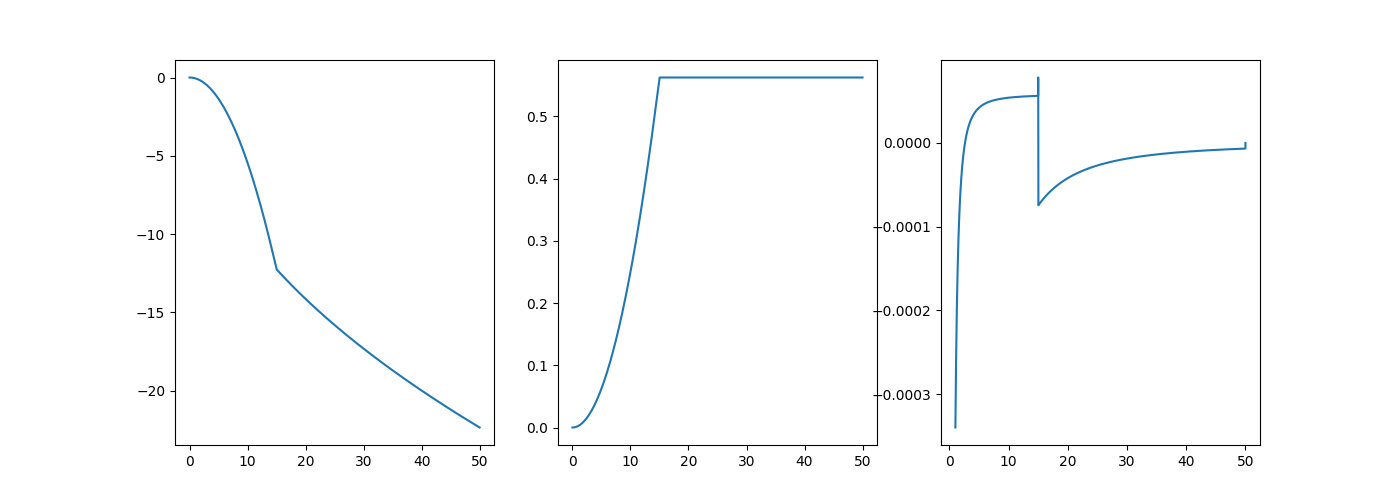

In [19]:
k = 0

fig, axs = plt.subplots(1, 3, figsize=(14,5))
axs[0].plot(wenor2[k]['x'], wenor2[k]['B'])
axs[1].plot(wenor2[k]['x'], wenor2[k]['eps'])
axs[2].plot(wenor2[k]['x'][100:], wenor2[k]['rho_dt'][100:])

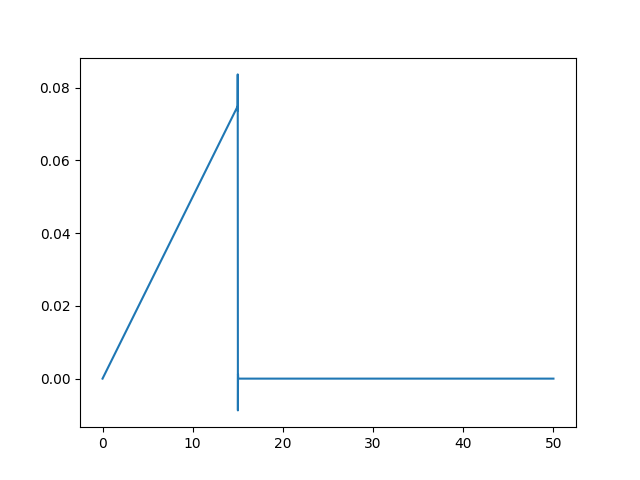

In [22]:
k = 0

fig = plt.figure()
plt.plot(wenor2[k]['x'], der(wenor2[k]['eps'], wenor2[k]['dx']))